In [8]:
import matplotlib.pyplot as plt
import re
import os
import numpy as np
from plots import plot_train_compare2, plot_train_compare

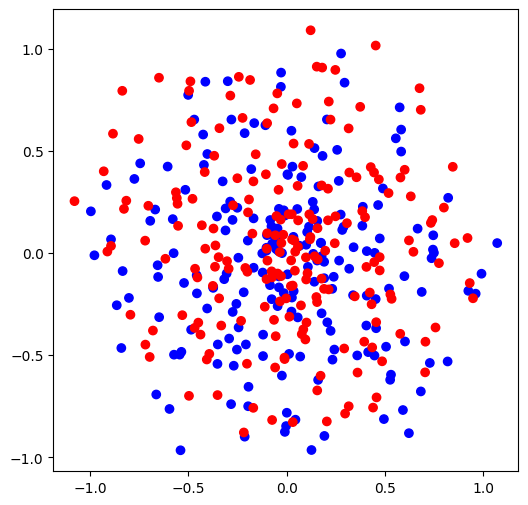

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral(n_samples, noise=0.2, turns=3):
    n = n_samples // 2  # Half samples per class
    theta = np.linspace(0, turns * 2 * np.pi, n)  # More turns for longer spirals
    r = np.linspace(0, 1, n)  # Increasing radius
    
    x1 = r * np.cos(theta) + np.random.normal(scale=noise, size=n)
    y1 = r * np.sin(theta) + np.random.normal(scale=noise, size=n)
    
    x2 = r * np.cos(theta + np.pi) + np.random.normal(scale=noise, size=n)  # Offset by π for proper separation
    y2 = r * np.sin(theta + np.pi) + np.random.normal(scale=noise, size=n)
    
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    y = np.hstack([np.zeros(n), np.ones(n)])
    
    return X, y

# Generate dataset
X, y = generate_spiral(400, noise=0.001, turns=4)  # More points and turns for better separation

# Plot the dataset
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.show()


In [9]:
def get_hp_args_from_txt(path):
    with open(path) as f:
        data_string = f.read()

        # Step 2: Define regex patterns to extract the values
        poison_lr_pattern = r"'poison_lr'\s*:\s*([0-9.]+)"
        iterations_pattern = r"'iterations'\s*:\s*(\d+)"
        epsilon_pattern = r"'epsilon'\s*:\s*([0-9.]+)"
        poison_start_epoch_pattern = r"'poison_start_epoch'\s*:\s*(\d+)"

        # Step 3: Extract the values using regex
        poison_lr = re.search(poison_lr_pattern, data_string).group(1)
        iterations = re.search(iterations_pattern, data_string).group(1)
        epsilon = re.search(epsilon_pattern, data_string).group(1)
        poison_start_epoch = re.search(poison_start_epoch_pattern, data_string).group(1)

        # Print the extracted values
        return (poison_lr, iterations, epsilon, poison_start_epoch)

def get_tests_vals_from_txt(path, one_run, epochs):
    vals = []
    tests = []
    vals_p = []
    tests_p = []
    with open(path) as f:
        highest_val = -1
        highest_val_p = -1
        highest_test = -1
        highest_test_p = -1
        i = 0
        for l in f.readlines():
            i += 1
            val_acc = float(re.findall(r"Val_accuracy:(\d+\.\d+)", l)[0])
            test_acc = float(re.findall(r"Test_accuracy:(\d+\.\d+)", l)[0])
            if i >= epochs*2:
                break
            elif i >= epochs and not one_run:
                if val_acc > highest_val_p:
                    highest_val_p = val_acc
                    highest_test_p = test_acc
                vals_p.append(val_acc)
                tests_p.append(test_acc)
            elif i < epochs or one_run:
                if val_acc > highest_val:
                    highest_val = val_acc
                    highest_test = test_acc
                vals.append(val_acc)
                tests.append(test_acc)
    return (vals, vals_p, highest_val, highest_val_p, tests, tests_p, highest_test, highest_test_p)
    
def construct_run_dicts(base_path, one_run=False, epochs=200):
    ids = next(os.walk(base_path))[1]
    runs = {}
    for id in ids:
        d = {}
        path = f"{base_path}/{id}/metrics.txt"
        vals, vals_p, highest_val, highest_val_p, tests, tests_p, highest_test, highest_test_p = get_tests_vals_from_txt(path, one_run, epochs)
        
        d["vals"] = vals
        d["vals_p"] = vals_p
        d["highest_val"] = highest_val
        d["highest_val_p"] = highest_val_p
        
        d["tests"] = tests
        d["tests_p"] = tests_p
        d["highest_test"] = highest_test
        d["highest_test_p"] = highest_test_p

        d["ratio"] = d["highest_val_p"]/d["highest_val"]

        runs[id] = d
    return runs



## FMNIST RESNET18

In [11]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/fmnist_res_net_18/poison_final')
runs_baseline = construct_run_dicts('experiment_results_from_eddie/fmnist_res_net_18/baseline_final')

highest_tests_sam_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_p_list = [runs_poison[d]["highest_test_p"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 91.98999999999998 +- 0.16451950239004176
Poison mean test: 91.99333333333333 +- 0.15003703246569375
Baseline mean test: 91.64333333333335 +- 0.44629337635436456


## CIFAR100 WIDE16

In [14]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar100_wide16/poison/train_w_poison', one_run=True)
runs_deltas = construct_run_dicts('experiment_results_from_eddie/cifar100_wide16/poison/deltas', one_run=True)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar100_wide16/baseline', one_run=True)

highest_tests_sam_list = [runs_deltas[d]["highest_test"] for d in runs_deltas]
highest_tests_p_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 67.27333333333334 +- 0.4644710252893417
Poison mean test: 70.12666666666668 +- 0.41547830535687447
Baseline mean test: 70.07666666666667 +- 0.22226110770892657


## CIFAR10 WIDE16

In [ ]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar10_wide16/poison/train_w_poison', one_run=True)
runs_deltas = construct_run_dicts('experiment_results_from_eddie/cifar10_wide16/poison/deltas', one_run=True)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar10_wide16/baseline', one_run=True)

highest_tests_sam_list = [runs_deltas[d]["highest_test"] for d in runs_deltas]
highest_tests_p_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 90.01333333333334 +- 0.25460208605237505
Poison mean test: 91.16 +- 0.23537204591879696
Baseline mean test: 91.78333333333333 +- 0.4079760341545086


## CIFAR10 WIDE16 Augmented

In [6]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar10_wide16/poison_aug', one_run=False)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar10_wide16/baseline_aug', one_run=False)

highest_tests_sam_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_p_list = [runs_poison[d]["highest_test_p"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 92.65666666666667 +- 0.1485485330343796
Poison mean test: 94.01666666666667 +- 0.13291601358251537
Baseline mean test: 93.51 +- 0.3151013946159079


## CIFAR100 WIDE28

In [11]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar100_wide28/poison', one_run=False)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar100_wide28/baseline', one_run=False)

highest_tests_sam_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_p_list = [runs_poison[d]["highest_test_p"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 69.02499999999999 +- 0.3723983828584088
Poison mean test: 72.3125 +- 0.4130467756669776
Baseline mean test: 70.96333333333334 +- 0.7793444538699049


## CIFAR100 WIDE16 Augmented

In [7]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar100_wide16/poison_aug', one_run=False)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar100_wide16/baseline_aug', one_run=False)

highest_tests_sam_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_p_list = [runs_poison[d]["highest_test_p"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 71.15666666666667 +- 0.349221356098902
Poison mean test: 73.49333333333333 +- 0.32396844839514294
Baseline mean test: 74.83 +- 0.34918953783487167


## CIFAR10 Dense

In [5]:
runs_poison = construct_run_dicts('experiment_results_from_eddie/cifar10_dense/poison', one_run=False)
runs_baseline = construct_run_dicts('experiment_results_from_eddie/cifar10_dense/baseline', one_run=False)

highest_tests_sam_list = [runs_poison[d]["highest_test"] for d in runs_poison]
highest_tests_p_list = [runs_poison[d]["highest_test_p"] for d in runs_poison]
highest_tests_baseline_list = [runs_baseline[d]["highest_test"] for d in runs_baseline]

print("SAM mean test:", np.mean(highest_tests_sam_list), "+-", np.std(highest_tests_sam_list))
print("Poison mean test:", np.mean(highest_tests_p_list), "+-", np.std(highest_tests_p_list))
print("Baseline mean test:", np.mean(highest_tests_baseline_list), "+-", np.std(highest_tests_baseline_list))

SAM mean test: 89.55666666666666 +- 0.2887905815638719
Poison mean test: 90.88 +- 0.14772346537439854
Baseline mean test: 89.87333333333333 +- 0.24004629183185183
